In [3]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load Data

In [4]:
# Define and initialize model
class NeuralNetworkMVEv2(nn.Module):
    def __init__(self, npix):
        super(NeuralNetworkMVEv2, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(8))
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(16))
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(32))
        self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=2, stride=2))

        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc1', nn.Linear(in_features=32*5*5, out_features=128))
        self.regressor.add_module('f_relu1', nn.ReLU(True))
        self.regressor.add_module('r_fc2', nn.Linear(in_features=128, out_features=32))
        self.regressor.add_module('r_sig2', nn.Sigmoid())
        self.regressor.add_module('r_fc3', nn.Linear(in_features=32, out_features=2))

        self.npix = npix

    def forward(self, x):
        x = x.view(-1, 3, self.npix, self.npix)

        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        estimate = self.regressor(features)
        estimate = F.relu(estimate)
        estimate = estimate.view(-1, 2)

        return estimate, features


    def get_feature(self, x):
        x = x.view(-1, 3, self.npix, self.npix)
        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        return features

In [5]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_lenscolor_source/mb_lenscolor_source.npy'
target_img_path = head / 'data/mb_lenscolor_target/mb_lenscolor_target.npy'
source_meta = head / 'data/mb_lenscolor_source/mb_lenscolor_source_metadata.csv'
target_meta = head / 'data/mb_lenscolor_target/mb_lenscolor_target_metadata.csv'
batch_size = 64
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

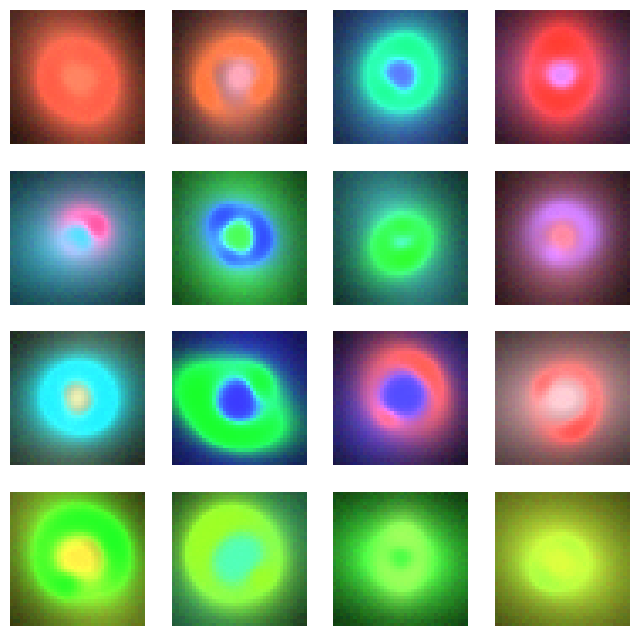

In [6]:
# Visualize source data
visualize_data(source_data)

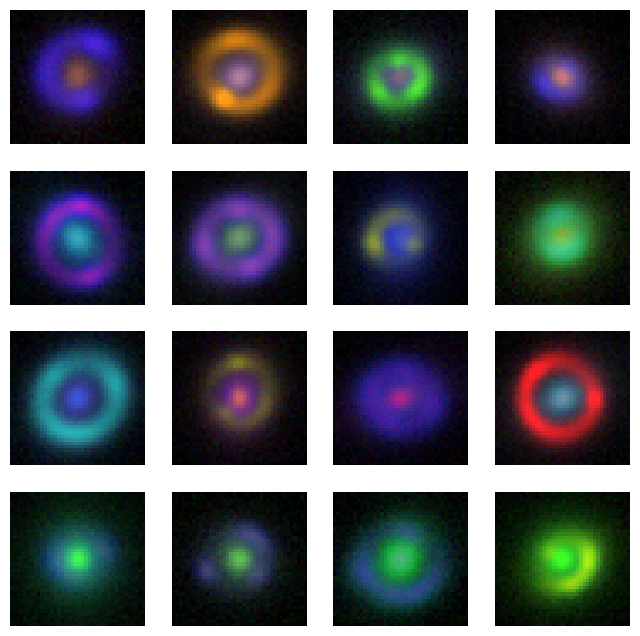

In [7]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [8]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    return da_weight

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)
    return beta_val

# Initialize hyperparameters
learning_rate = 3e-5
n_epoch = 250
init_wt_da = 1.4
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.0

In [9]:
# Initialize model
model = NeuralNetworkMVEv2(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
from torchsummary import summary
summary(model, (3, 40, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 40, 40]             224
              ReLU-2            [-1, 8, 40, 40]               0
       BatchNorm2d-3            [-1, 8, 40, 40]              16
         MaxPool2d-4            [-1, 8, 20, 20]               0
            Conv2d-5           [-1, 16, 20, 20]           1,168
              ReLU-6           [-1, 16, 20, 20]               0
       BatchNorm2d-7           [-1, 16, 20, 20]              32
         MaxPool2d-8           [-1, 16, 10, 10]               0
            Conv2d-9           [-1, 32, 10, 10]           4,640
             ReLU-10           [-1, 32, 10, 10]               0
      BatchNorm2d-11           [-1, 32, 10, 10]              64
        MaxPool2d-12             [-1, 32, 5, 5]               0
           Linear-13                  [-1, 128]         102,528
             ReLU-14                  [

In [11]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None # "models/start_code_test_2"
stats, model, optimizer, best_target_R2, best_mve_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/mve_v8_NNv2_aug5_0040"

## Train

Beginning Training...
Generating Isomap...


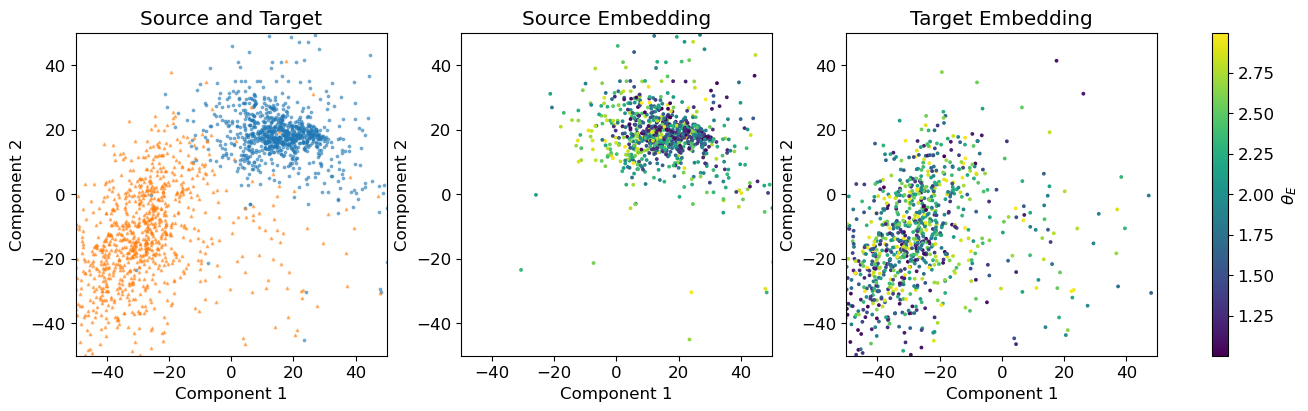


Epoch 0: 11.52s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1916
	Train Regression Loss: : 1.3986
	Train Mve Loss: : 0.7264
	Train R2 Score: : -3.2769
 Validation Statistics:
	Val Source Regression Loss: : 0.5723
	Val Target Regression Loss: : 0.5500
	Val Source R2 Score: : -0.7448
	Val Target R2 Score: : -0.6973
	Val Source Mve Loss: : 0.1917
	Val Target Mve Loss: : 0.1806
Saving Model... Done.
Saving Model MVE... Done.

Epoch 1: 10.91s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0932
	Train Regression Loss: : 0.4637
	Train Mve Loss: : 0.0833
	Train R2 Score: : -0.4152
 Validation Statistics:
	Val Source Regression Loss: : 0.3901
	Val Target Regression Loss: : 0.3833
	Val Source R2 Score: : -0.1843
	Val Target R2 Score: : -0.1812
	Val Source Mve Loss: : 0.0299
	Val Target Mve Loss: : 0.0263
Saving Model... Done.
Saving Model MVE... Done.

Epoch 2: 9.53s
-------------------------------
 Training Statistics:
	Train Da Loss: : 

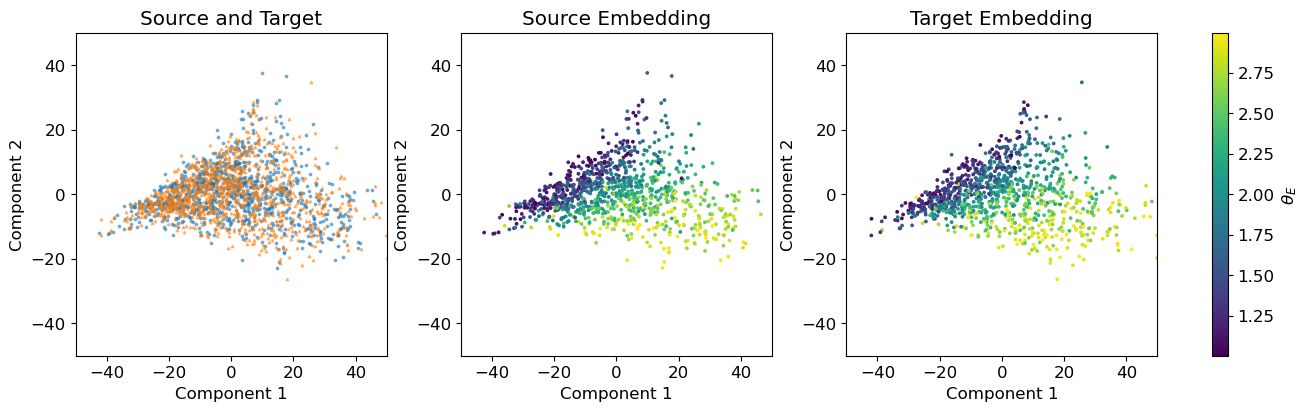

Saving Model MVE... Done.

Epoch 20: 11.19s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0712
	Train Regression Loss: : 0.0225
	Train Mve Loss: : -0.0575
	Train R2 Score: : 0.9310
 Validation Statistics:
	Val Source Regression Loss: : 0.0239
	Val Target Regression Loss: : 0.0269
	Val Source R2 Score: : 0.9280
	Val Target R2 Score: : 0.9166
	Val Source Mve Loss: : -0.0442
	Val Target Mve Loss: : -0.0425
Saving Model... Done.

Epoch 21: 10.83s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0691
	Train Regression Loss: : 0.0217
	Train Mve Loss: : -0.0404
	Train R2 Score: : 0.9332
 Validation Statistics:
	Val Source Regression Loss: : 0.0223
	Val Target Regression Loss: : 0.0255
	Val Source R2 Score: : 0.9321
	Val Target R2 Score: : 0.9208
	Val Source Mve Loss: : -0.0334
	Val Target Mve Loss: : -0.0313
Saving Model... Done.

Epoch 22: 10.39s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0697
	Train Regressi

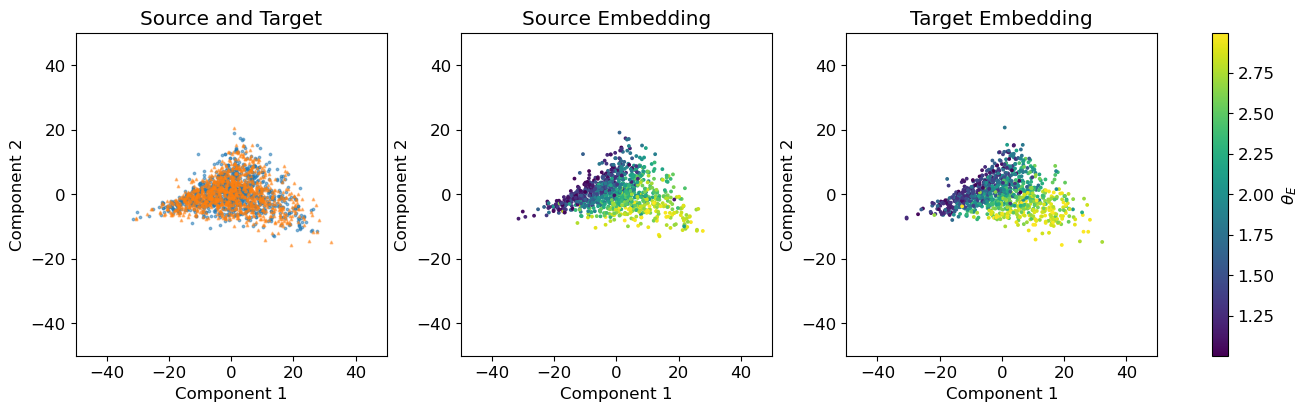

Saving Model... Done.

Epoch 40: 13.96s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0729
	Train Regression Loss: : 0.0165
	Train Mve Loss: : -0.0462
	Train R2 Score: : 0.9492
 Validation Statistics:
	Val Source Regression Loss: : 0.0171
	Val Target Regression Loss: : 0.0211
	Val Source R2 Score: : 0.9480
	Val Target R2 Score: : 0.9344
	Val Source Mve Loss: : -0.0515
	Val Target Mve Loss: : -0.0470

Epoch 41: 10.53s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0737
	Train Regression Loss: : 0.0160
	Train Mve Loss: : -0.0514
	Train R2 Score: : 0.9509
 Validation Statistics:
	Val Source Regression Loss: : 0.0172
	Val Target Regression Loss: : 0.0209
	Val Source R2 Score: : 0.9475
	Val Target R2 Score: : 0.9346
	Val Source Mve Loss: : -0.0406
	Val Target Mve Loss: : -0.0357
Saving Model... Done.

Epoch 42: 11.43s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0747
	Train Regression Loss: : 0.0157
	Train M

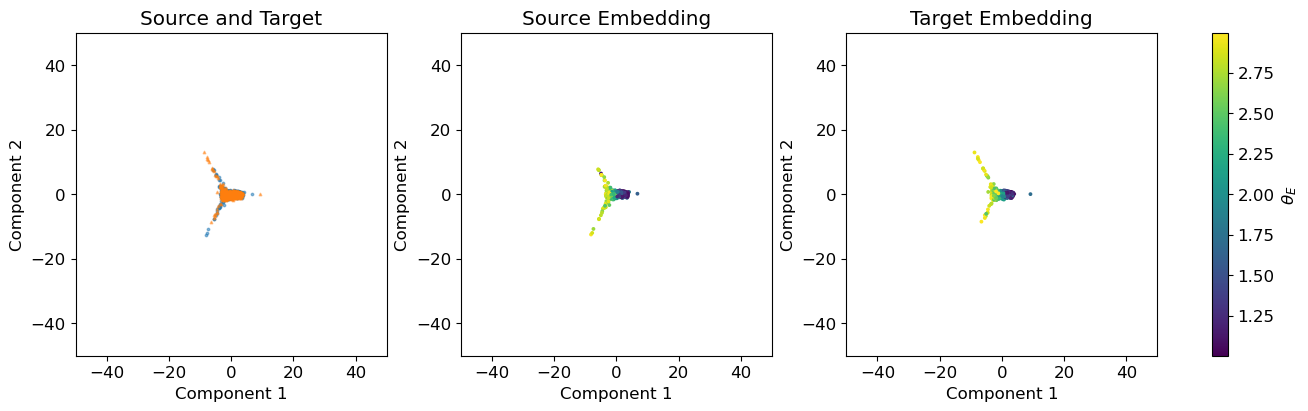


Epoch 60: 11.04s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0791
	Train Regression Loss: : 0.0208
	Train Mve Loss: : -0.0716
	Train R2 Score: : 0.9362
 Validation Statistics:
	Val Source Regression Loss: : 0.0218
	Val Target Regression Loss: : 0.0245
	Val Source R2 Score: : 0.9335
	Val Target R2 Score: : 0.9240
	Val Source Mve Loss: : -0.0569
	Val Target Mve Loss: : -0.0478

Epoch 61: 11.94s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0789
	Train Regression Loss: : 0.0210
	Train Mve Loss: : -0.0713
	Train R2 Score: : 0.9356
 Validation Statistics:
	Val Source Regression Loss: : 0.0215
	Val Target Regression Loss: : 0.0243
	Val Source R2 Score: : 0.9344
	Val Target R2 Score: : 0.9254
	Val Source Mve Loss: : -0.0747
	Val Target Mve Loss: : -0.0709

Epoch 62: 12.12s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0782
	Train Regression Loss: : 0.0214
	Train Mve Loss: : -0.0745
	Train R2 Score: : 0.9343

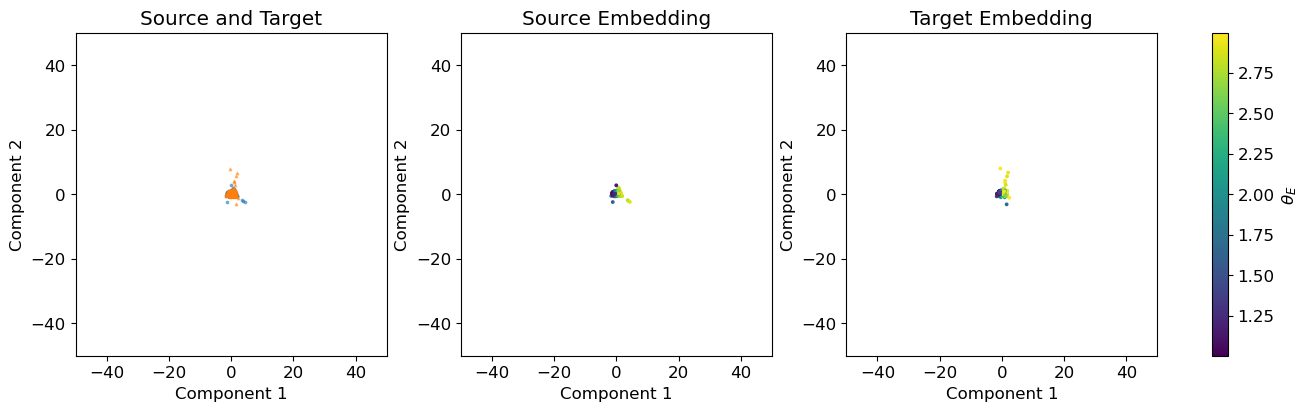


Epoch 80: 11.28s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0767
	Train Regression Loss: : 0.0215
	Train Mve Loss: : -0.0999
	Train R2 Score: : 0.9339
 Validation Statistics:
	Val Source Regression Loss: : 0.0240
	Val Target Regression Loss: : 0.0254
	Val Source R2 Score: : 0.9262
	Val Target R2 Score: : 0.9220
	Val Source Mve Loss: : -0.0715
	Val Target Mve Loss: : -0.0737

Epoch 81: 9.73s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0772
	Train Regression Loss: : 0.0207
	Train Mve Loss: : -0.0998
	Train R2 Score: : 0.9365
 Validation Statistics:
	Val Source Regression Loss: : 0.0217
	Val Target Regression Loss: : 0.0239
	Val Source R2 Score: : 0.9340
	Val Target R2 Score: : 0.9261
	Val Source Mve Loss: : -0.0599
	Val Target Mve Loss: : -0.0611

Epoch 82: 12.06s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0767
	Train Regression Loss: : 0.0208
	Train Mve Loss: : -0.1011
	Train R2 Score: : 0.9362


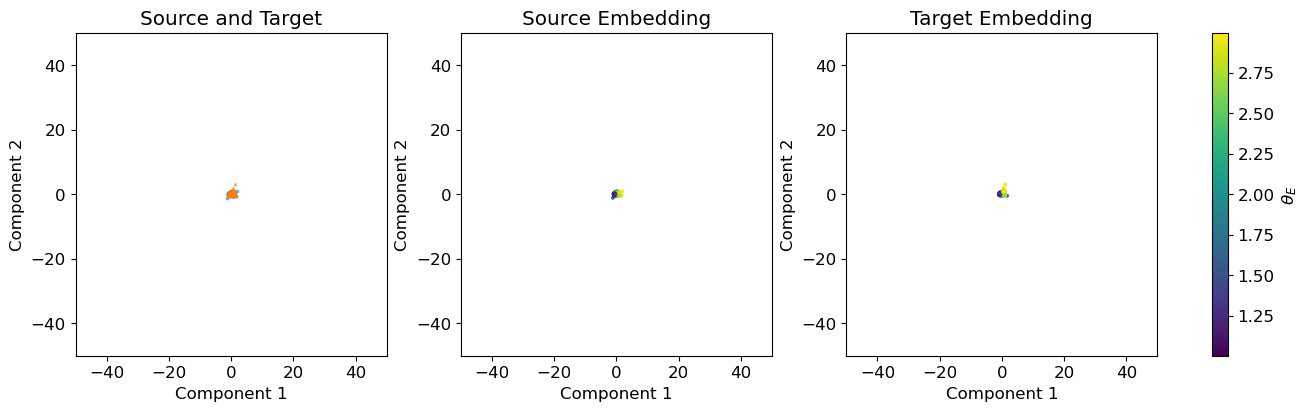


Epoch 100: 10.33s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0809
	Train Regression Loss: : 0.0199
	Train Mve Loss: : -0.1345
	Train R2 Score: : 0.9388
 Validation Statistics:
	Val Source Regression Loss: : 0.0263
	Val Target Regression Loss: : 0.0295
	Val Source R2 Score: : 0.9185
	Val Target R2 Score: : 0.9081
	Val Source Mve Loss: : -0.0749
	Val Target Mve Loss: : -0.0758

Epoch 101: 11.19s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0806
	Train Regression Loss: : 0.0207
	Train Mve Loss: : -0.1385
	Train R2 Score: : 0.9365
 Validation Statistics:
	Val Source Regression Loss: : 0.0197
	Val Target Regression Loss: : 0.0222
	Val Source R2 Score: : 0.9399
	Val Target R2 Score: : 0.9299
	Val Source Mve Loss: : -0.1181
	Val Target Mve Loss: : -0.1367

Epoch 102: 10.81s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0799
	Train Regression Loss: : 0.0198
	Train Mve Loss: : -0.1382
	Train R2 Score: : 0.9

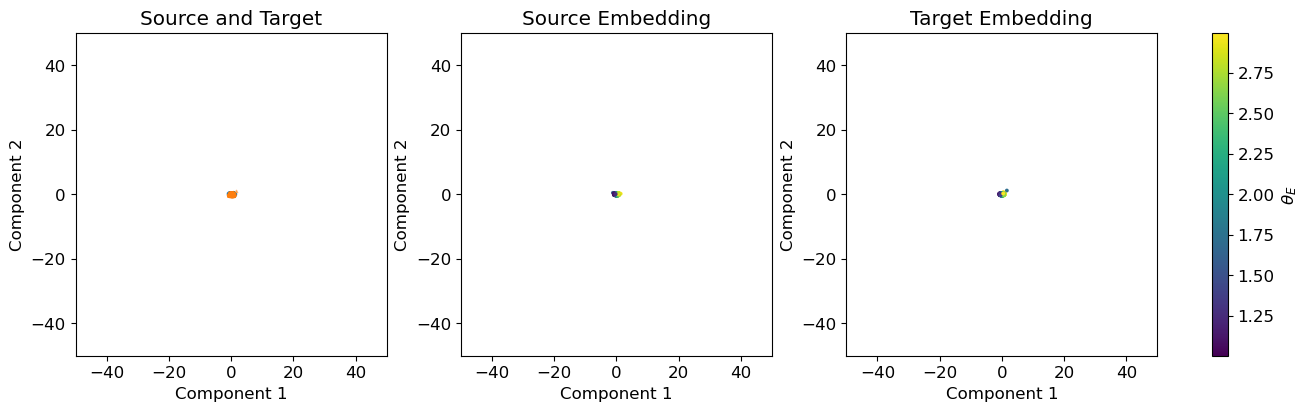


Epoch 120: 11.06s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0803
	Train Regression Loss: : 0.0203
	Train Mve Loss: : -0.1980
	Train R2 Score: : 0.9376
 Validation Statistics:
	Val Source Regression Loss: : 0.0207
	Val Target Regression Loss: : 0.0231
	Val Source R2 Score: : 0.9376
	Val Target R2 Score: : 0.9255
	Val Source Mve Loss: : -0.1674
	Val Target Mve Loss: : -0.1596

Epoch 121: 11.10s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0798
	Train Regression Loss: : 0.0370
	Train Mve Loss: : -0.2145
	Train R2 Score: : 0.8868
 Validation Statistics:
	Val Source Regression Loss: : 0.0756
	Val Target Regression Loss: : 0.0772
	Val Source R2 Score: : 0.7710
	Val Target R2 Score: : 0.7605
	Val Source Mve Loss: : -0.2624
	Val Target Mve Loss: : -0.2609
Saving Model MVE... Done.

Epoch 122: 11.27s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0769
	Train Regression Loss: : 0.0662
	Train Mve Loss: : -0.2

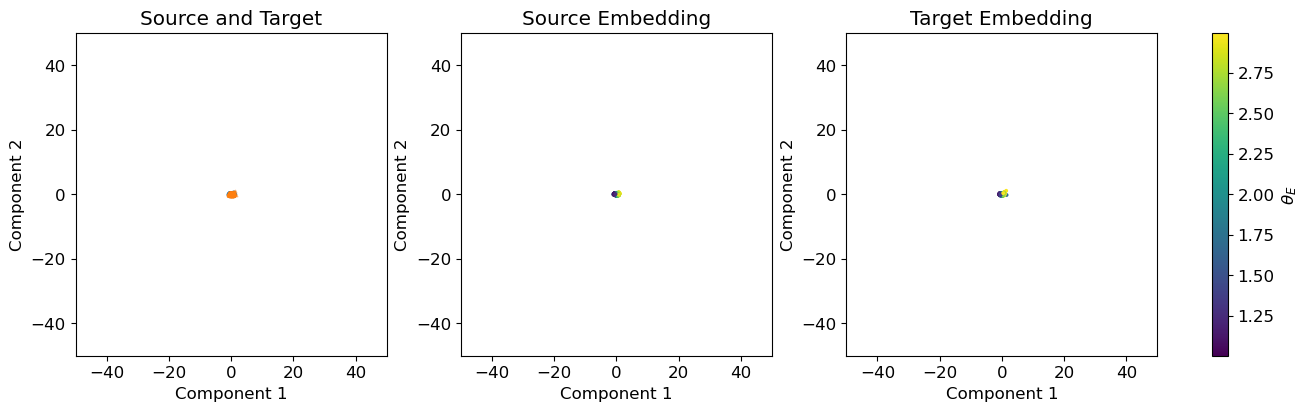


Epoch 140: 10.04s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0821
	Train Regression Loss: : 0.0186
	Train Mve Loss: : -0.2527
	Train R2 Score: : 0.9430
 Validation Statistics:
	Val Source Regression Loss: : 0.0188
	Val Target Regression Loss: : 0.0212
	Val Source R2 Score: : 0.9427
	Val Target R2 Score: : 0.9346
	Val Source Mve Loss: : 0.1017
	Val Target Mve Loss: : -0.2122

Epoch 141: 11.64s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0813
	Train Regression Loss: : 0.0184
	Train Mve Loss: : -0.2553
	Train R2 Score: : 0.9435
 Validation Statistics:
	Val Source Regression Loss: : 0.0189
	Val Target Regression Loss: : 0.0209
	Val Source R2 Score: : 0.9417
	Val Target R2 Score: : 0.9350
	Val Source Mve Loss: : -0.2483
	Val Target Mve Loss: : -0.2398

Epoch 142: 11.64s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0810
	Train Regression Loss: : 0.0178
	Train Mve Loss: : -0.2587
	Train R2 Score: : 0.94

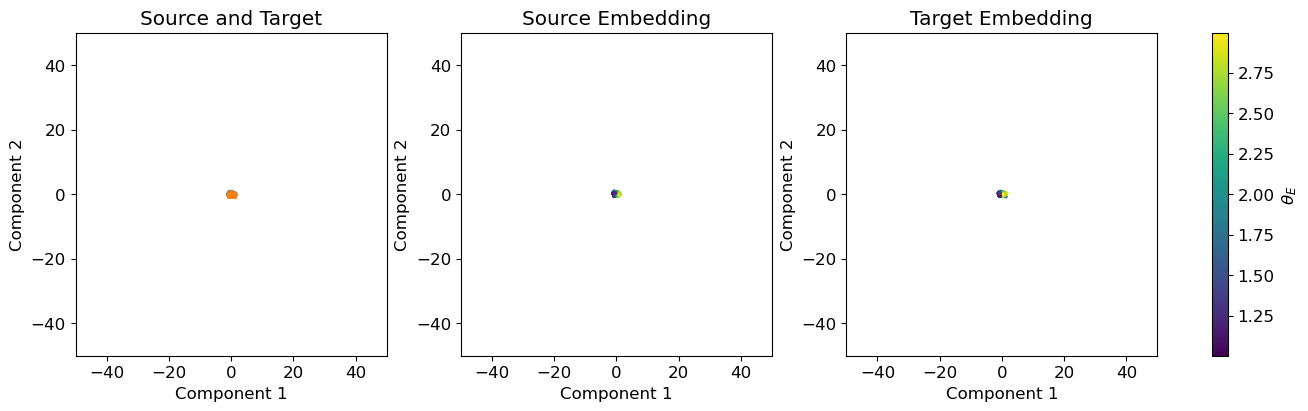


Epoch 160: 11.46s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0801
	Train Regression Loss: : 0.0190
	Train Mve Loss: : -0.3470
	Train R2 Score: : 0.9416
 Validation Statistics:
	Val Source Regression Loss: : 0.0198
	Val Target Regression Loss: : 0.0221
	Val Source R2 Score: : 0.9396
	Val Target R2 Score: : 0.9298
	Val Source Mve Loss: : 0.8301
	Val Target Mve Loss: : -0.3244

Epoch 161: 11.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0805
	Train Regression Loss: : 0.0191
	Train Mve Loss: : -0.3549
	Train R2 Score: : 0.9416
 Validation Statistics:
	Val Source Regression Loss: : 0.0214
	Val Target Regression Loss: : 0.0238
	Val Source R2 Score: : 0.9343
	Val Target R2 Score: : 0.9260
	Val Source Mve Loss: : 0.9078
	Val Target Mve Loss: : -0.3162

Epoch 162: 11.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0799
	Train Regression Loss: : 0.0193
	Train Mve Loss: : -0.3625
	Train R2 Score: : 0.940

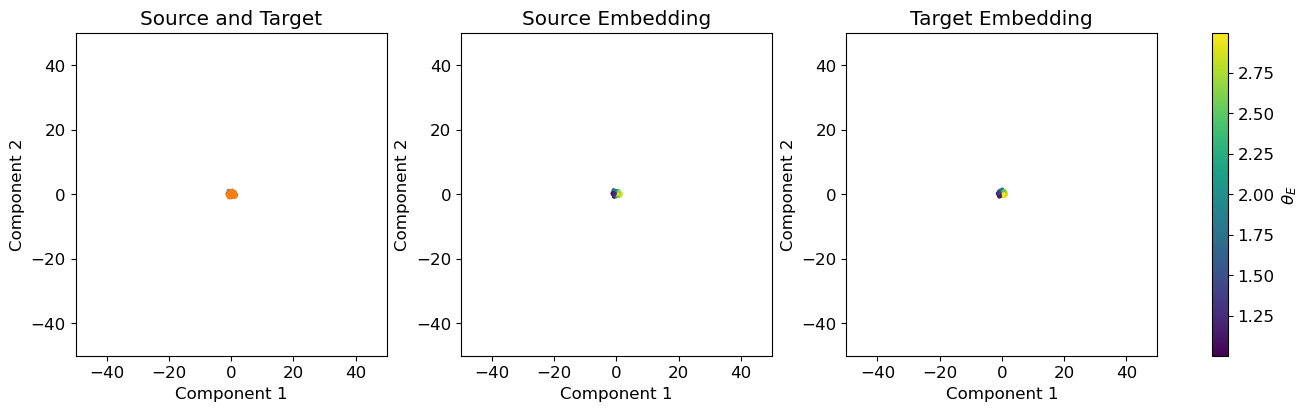

In [ ]:
print("Beginning Training...")


for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1

        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [ ]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [ ]:
# Loads a model for plotting/viz

viz_mod_name = final_mod_name # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

In [ ]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 2)

In [ ]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

In [ ]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

In [ ]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [ ]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [ ]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [ ]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

In [ ]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

In [ ]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()